# Imports

In [1]:
from data_classes import LAQNData, HealthData
from os import path
import pandas as pd

# Load data

### Load the hourly NO$_2$ data

In [2]:
data_folder = path.join(path.abspath(""), "LAQN_data")
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [3]:
NO2_hourly = LAQNData(url, data_folder, species, start_date, end_date)

In [4]:
hourly_df = NO2_hourly.read_csv(index_col="date")
print(hourly_df.shape)

Reading NO2_hourly_2000-01-01_2021-01-01.csv...
(184105, 192)


### Load the weekly mortality per capita data

In [6]:
data_folder = path.join(path.abspath(""), "mortality_data")
filename = "weekly_mortality_percapita_London.csv"

In [7]:
mortality_weekly = HealthData(data_folder, filename=filename)

In [8]:
mortality_df = pd.DataFrame(mortality_weekly.read_csv(index_col="date"))
print(mortality_df.shape)

Reading weekly_mortality_percapita_London.csv...
(495, 3)


# Process data

### Resample the hourly NO$_2$ data using a custom date list

In [10]:
weekly_dates = mortality_df.index

Only retain the NO$_2$ data up to the final mortality datapoint:

In [11]:
hourly_df = hourly_df.loc[hourly_df.index < weekly_dates.max()]

In [12]:
weekly_NO2_df = hourly_df.groupby(weekly_dates[weekly_dates.searchsorted(hourly_df.index)]).mean()

We've now generated a dataframe of weekly mean NO$_2$ concentrations (from the hourly data) using the weekly dates given by the mortality dataset. 
- The `searchsorted()` function takes the `hourly_df` index and inserts it into `weekly_dates` to return an array of indices where the hourly elements should be inserted to maintain order in the weekly dates. See docs [here](https://pandas.pydata.org/pandas-docs/version/0.21.1/generated/pandas.DatetimeIndex.searchsorted.html).
- Placing these indices inside `weekly_dates[]` produces an array the same length as the hourly index, where each entry is the corresponding "weekly" date.
- The `groupby()` operation then performs the `mean()` function on the hourly data, grouping by the assigned weekly dates in the previous step. See docs [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html).

### Spatially average the NO$_2$ data for all of London

In [13]:
NO2_df = pd.DataFrame(weekly_NO2_df.mean(axis=1), columns=["mean_NO2"]).join(mortality_df)

In [17]:
NO2_df.head()

,mean_NO2,total_population,weekly_deaths,deaths_per_capita
date,,,,
2010-01-08,54.274204,8.004813e+06,1226.0,0.000153
2010-01-15,59.165384,8.007094e+06,1262.0,0.000158
2010-01-22,67.432424,8.009374e+06,1186.0,0.000148
2010-01-29,64.820489,8.011654e+06,1093.0,0.000136
2010-02-05,67.035762,8.013935e+06,1035.0,0.000129


<AxesSubplot:xlabel='mean_NO2', ylabel='deaths_per_capita'>

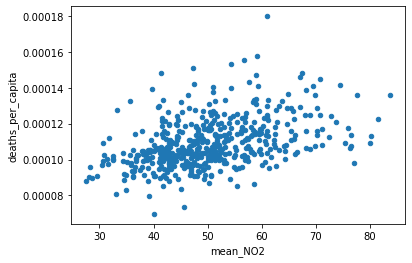

In [16]:
NO2_df.plot.scatter(x="mean_NO2", y="deaths_per_capita")